## 2 Layer MLP for Dark Knoweldge Experiments w/AlignMNIST

75 epochs of RMSProp on AlignMNIST

Bigger network with dropout yet, and trying to add some kind of weight constraint / max norm 

for now, looking at norms on each layer


see  http://www.r2rt.com/posts/implementations/2016-03-29-implementing-batch-normalization-tensorflow/

https://github.com/tensorflow/tensorflow/blob/b3621c95160a916d4d255f9f44318b9d465701af/tensorflow/contrib/layers/python/layers/layers.py


https://www.reddit.com/r/MachineLearning/comments/2bopxs/question_about_the_maxnorm_constraint_used_with/



https://arxiv.org/pdf/1207.0580.pdf

https://arxiv.org/pdf/1503.02531v1.pdf

http://www.kdnuggets.com/2015/04/preventing-overfitting-neural-networks.html

https://www.reddit.com/r/MachineLearning/comments/2bopxs/question_about_the_maxnorm_constraint_used_with/

and https://github.com/tensorflow/tensorflow/issues/608

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
%run augmentmnist.py

In [3]:
num_epochs = 75
batch_size = 125

learning_rate = 0.001


In [4]:
# Network Parameters
n_hidden_1 = 1200 # 1st layer num features
n_hidden_2 = 1200 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

std_0  = np.sqrt(6.0/(n_input+n_hidden_1))
std_h1 = np.sqrt(6.0/(n_hidden_1+n_hidden_2))
std_h2 = np.sqrt(6.0/(n_hidden_2+n_classes))

logfile = "2BwD-layer-dlk-alignmnist-3"

In [5]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

xt = tf.placeholder("float", [None, n_input])
yt = tf.placeholder("float", [None, n_classes])

In [6]:
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])),  0.2)
    layer_2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2'])), 0.5)    
    return tf.matmul(layer_2, weights['out']) + biases['out']

In [7]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=std_h2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.001))
}

In [8]:
mlp = multilayer_perceptron(x, weights, biases )
mlp_test = multilayer_perceptron(xt, weights, biases  )

In [9]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mlp, y)) 
gs = tf.get_variable("global_step",[],trainable=False,initializer=tf.constant_initializer(0))
lr = tf.constant(learning_rate) 

In [10]:
train_op = tf.contrib.layers.optimize_loss(cost, global_step=gs, learning_rate=lr,optimizer="RMSProp")

In [11]:
#with tf.name_scope("training accuracy"):
pred = tf.equal(tf.argmax(mlp, 1), tf.argmax(y, 1)) # Count correct predictions
train_acc_op = tf.reduce_mean(tf.cast(pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("training accuracy", train_acc_op)

<tf.Tensor 'ScalarSummary_2:0' shape=() dtype=string>

In [12]:
test_pred = tf.equal(tf.argmax(mlp_test, 1), tf.argmax(yt, 1)) # Count correct predictions
test_acc_op = tf.reduce_mean(tf.cast(test_pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("test 0 accuracy", test_acc_op)

<tf.Tensor 'ScalarSummary_3:0' shape=() dtype=string>

In [13]:
!rm -rf ./logs/{logfile}
!ls logs

2-layer-dk-alignmnist           2-layer-modern-mlp-alignmnist
2-layer-dlk-alignmnist          2BwD-layer-dlk-alignmnist
2-layer-mlp-alignmnist-wdropout 5-layer-mlp-alignmnist-wdropout
2-layer-mlp-mnist-temp          5-layer-mlp-infimnist
2-layer-mlp-mnist-watch


### Original MNIST Data

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)
trX_0, trY_0 = mnist.train.images, mnist.train.labels
teX_0, teY_0 = mnist.test.images, mnist.test.labels

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [15]:
alignmnist = AlignMNIST()

In [22]:
test_accuracies = []
train_accuracies = []
norms = []
with tf.Session() as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/{logfile}'
    writer = tf.train.SummaryWriter("./logs/{0}".format(logfile), sess.graph) # for 0.8
    merged = tf.merge_all_summaries()
 
    tf.initialize_all_variables().run()

    for epoch in range(num_epochs):
        trX, trY = alignmnist.next_epoch()
      
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX), batch_size)):
            sess.run(train_op, feed_dict={x: trX[start:end], y: trY[start:end]})
                 
        summary, trn_acc, tst_acc = sess.run([merged, train_acc_op, test_acc_op], feed_dict={x: trX, y: trY, xt: teX_0, yt: teY_0})
        writer.add_summary(summary, epoch)  
        
        
        print(epoch, trn_acc, tst_acc)
        train_accuracies.append(trn_acc)
        test_accuracies.append(tst_acc)

        nrms= [np.linalg.norm(weights['h1'].eval()),np.linalg.norm(weights['h2'].eval()), np.linalg.norm(weights['out'].eval()), np.linalg.norm(biases['b1'].eval()),np.linalg.norm(biases['b2'].eval()),np.linalg.norm(biases['out'].eval())]
        print nrms
        norms.append(nrms)
        writer.flush()
        

(0, 0.81511664, 0.88749999)
[54.569935, 62.339447, 6.9963851, 3.448611, 1.0789102, 0.082129896]
(1, 0.86266667, 0.91829997)
[56.05917, 65.244644, 6.5838289, 3.5065219, 2.1609182, 0.17845699]
(2, 0.88026667, 0.92940003)
[57.390232, 67.908058, 6.3219166, 3.5616927, 3.3341305, 0.27384359]
(3, 0.89233333, 0.9386)
[58.672428, 70.474121, 6.2681961, 3.6408212, 4.4861813, 0.36348552]
(4, 0.89481664, 0.94099998)
[59.879402, 72.952095, 6.3676305, 3.7453721, 5.5518999, 0.45345449]
(5, 0.90166664, 0.94340003)
[61.056767, 75.36821, 6.6044264, 3.8553052, 6.585577, 0.55994248]
(6, 0.90773332, 0.95039999)
[62.184849, 77.724831, 6.9394088, 3.992049, 7.5731235, 0.64984828]
(7, 0.90786666, 0.94679999)
[63.217308, 79.973152, 7.2663913, 4.1529312, 8.5597239, 0.75256306]
(8, 0.90481669, 0.94709998)
[64.219734, 82.17511, 7.6462321, 4.2979636, 9.5112324, 0.8630808]
(9, 0.91521668, 0.95020002)
[65.212883, 84.351112, 8.066247, 4.4625301, 10.426193, 0.94609499]
(10, 0.90969998, 0.94870001)
[66.108734, 86.468483,

In [23]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

/Users/charlesmartin14/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [25]:
np.max(test_accuracies)

0.9619

Number test errors is

In [26]:
10000*(1.0-np.max(test_accuracies))

381.00004196166992

In [31]:
print norms[0]
print norms[-1]

[54.569935, 62.339447, 6.9963851, 3.448611, 1.0789102, 0.082129896]
[102.45666, 162.9534, 40.922997, 18.756783, 53.30151, 3.2270765]


#### What is the best way to implement the cutoff ?

by the norm of the weights at each layer ?

see also:  http://keras.io/constraints/

Does this just reflect the loss decreasing ?

Can we simply bound the norm?

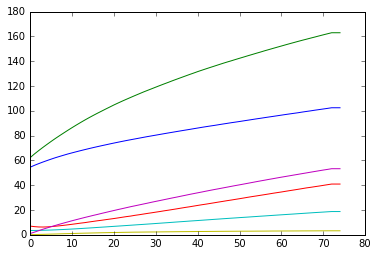

In [37]:
for i in range(6):
    plt.plot([nrm[i] for nrm in norms])